In [1]:
import sys
import os

# Get the path of the project root directory 
# Assumes you are running jupyter lab from inside the 'earth-intelligence-platform' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path so Python can find 'eintelligence'
if project_root not in sys.path:
    sys.path.append(project_root)
    
print(f"Project root added to path: {project_root}")


Project root added to path: /home/hegde/code/earth-api


In [4]:
# %% GPU-friendly training loop (mixed precision)
import os, torch
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from pathlib import Path
import albumentations as A

from eintelligence.data_prep.dataset import Sentinel2TileDataset
from eintelligence.backbone.resnet_encoder import ResNetBackbone
from eintelligence.adapters.seg_head import SimpleUNetHead

In [5]:
# paths
scene_dir = Path(project_root) / "data" / "S2B_MSIL2A_20230720T183929_R070_T10SGF_20240817T204416"  
tiles_dir = scene_dir / "tiles_s2"
manifest_path = tiles_dir / "manifest.json"



In [6]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

In [7]:
ds = Sentinel2TileDataset(
    tiles_dir=tiles_dir,
    manifest_path=manifest_path,
    band_names=("B02","B03","B04","B08"),
    ndvi_threshold=0.3,      # pseudo-label
    normalize=True,
    augment=augment,
    use_uint16_reflectance=True,
)

In [8]:
# train/val split
val_frac = 0.2
n_val = int(len(ds)*val_frac)
n_train = len(ds)-n_val
train_ds, val_ds = random_split(ds, [n_train, n_val])

# DataLoaders (GPU best practices: pin_memory + non_blocking later)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # speed autotuning for fixed-size tiles

In [10]:
# Model
enc = ResNetBackbone(in_channels=4).to(device)
head = SimpleUNetHead(feat_channels=(64,128,256,512), out_ch=1).to(device)
params = list(enc.parameters()) + list(head.parameters())

optimizer = torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4)
scaler = GradScaler(enabled=(device.type=="cuda"))

def bce_dice_loss(logits, target, eps=1e-6):
    bce = F.binary_cross_entropy_with_logits(logits, target)
    probs = torch.sigmoid(logits)
    inter = (probs*target).sum(dim=(2,3))
    dice = 1 - (2*inter + eps) / (probs.sum(dim=(2,3)) + target.sum(dim=(2,3)) + eps)
    return bce + dice.mean()

def run_epoch(loader, train=True):
    if train:
        enc.train(); head.train()
    else:
        enc.eval(); head.eval()

    total = 0.0
    with torch.set_grad_enabled(train):
        for x, y, meta in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with autocast(enabled=(device.type=="cuda")):
                feats = enc(x)
                logits = head(feats)
                loss = bce_dice_loss(logits, y)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total += loss.item()*x.size(0)
    return total/len(loader.dataset)

best = 1e9

/tmp/ipykernel_65086/627015673.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type=="cuda"))


In [13]:
models_dir = Path(project_root) / "models"
models_dir.mkdir(parents=True, exist_ok=True)

for epoch in range(10):
    tr = run_epoch(train_loader, train=True)
    va = run_epoch(val_loader, train=False)
    print(f"epoch {epoch:02d} | train {tr:.4f} | val {va:.4f}")
    if va < best:
        best = va
        torch.save({"enc": enc.state_dict(), "head": head.state_dict()}, models_dir / "vegmask_resnet18.pt")
        print("saved checkpoint -> models/vegmask_resnet18.pt")

/tmp/ipykernel_65086/627015673.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


epoch 00 | train 0.3400 | val 0.3589
saved checkpoint -> models/vegmask_resnet18.pt
epoch 01 | train 0.3087 | val 0.3682
epoch 02 | train 0.2889 | val 0.2738
saved checkpoint -> models/vegmask_resnet18.pt
epoch 03 | train 0.2559 | val 0.2784
epoch 04 | train 0.2533 | val 0.2460
saved checkpoint -> models/vegmask_resnet18.pt
epoch 05 | train 0.2423 | val 0.2294
saved checkpoint -> models/vegmask_resnet18.pt
epoch 06 | train 0.2361 | val 0.2324
epoch 07 | train 0.2298 | val 0.2308
epoch 08 | train 0.2273 | val 0.2407
epoch 09 | train 0.2268 | val 0.2259
saved checkpoint -> models/vegmask_resnet18.pt


In [14]:
# %% inference on a few tiles and save masks
import torch, rasterio
from rasterio.transform import Affine
import numpy as np
from pathlib import Path

models_dir = Path(project_root) / "models"

ckpt = torch.load(models_dir / "vegmask_resnet18.pt", map_location=device)
enc.load_state_dict(ckpt["enc"]); head.load_state_dict(ckpt["head"])
enc.eval(); head.eval()


out_dir = Path(project_root) / "predictions" / scene_dir / "pred_masks"
out_dir.mkdir(exist_ok=True)

count = 0
for x, _, meta in val_loader:
    x = x.to(device, non_blocking=True)
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
        logits = head(enc(x))
        probs = torch.sigmoid(logits).float().cpu().numpy()  # [B,1,H,W]
    for b in range(x.size(0)):
        mask = (probs[b,0] > 0.5).astype(np.uint8)*255
        src_path = Path(meta["path"][b])
        with rasterio.open(src_path) as src:
            profile = src.profile
            profile.update(count=1, dtype="uint8", compress="deflate")
            out_path = out_dir / (src_path.stem + "_vegmask.tif")
            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(mask, 1)
        count += 1
        if count >= 8:
            break
    if count >= 8:
        break

print("Wrote a few mask tiles to:", out_dir)


/tmp/ipykernel_65086/3035943853.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Wrote a few mask tiles to: /home/hegde/code/earth-api/data/S2B_MSIL2A_20230720T183929_R070_T10SGF_20240817T204416/pred_masks


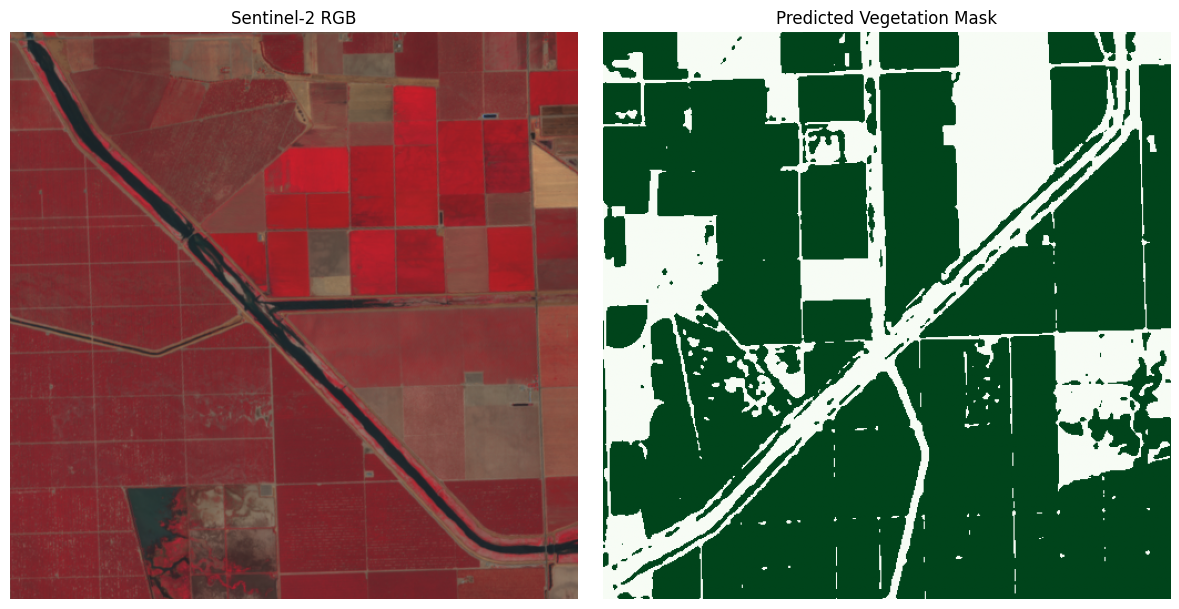

In [16]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

tile_path = Path(project_root) / "data" / "S2B_MSIL2A_20230720T183929_R070_T10SGF_20240817T204416" / "tiles_s2" / "r0000_c0011.tif"
mask_path = Path(project_root) / "data" / "S2B_MSIL2A_20230720T183929_R070_T10SGF_20240817T204416" / "pred_masks" / "r0000_c0011_vegmask.tif"

with rasterio.open(tile_path) as src:
    rgb = np.stack([
        src.read(4),  # Red
        src.read(3),  # Green
        src.read(2)   # Blue
    ], axis=-1)
    rgb = np.clip(rgb / 10000.0, 0, 1)  # scale reflectance 0–1

with rasterio.open(mask_path) as m:
    mask = m.read(1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Sentinel-2 RGB")
plt.imshow(rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Predicted Vegetation Mask")
plt.imshow(mask, cmap="Greens")
plt.axis("off")

plt.tight_layout()
plt.show()
